In [140]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
!pip install tensorflow --quiet

In [4]:
!pip install matplotlib --upgrade --quiet

### Read in dataset
Data is collected in the data_generation notebook.

In [141]:
data = pd.read_csv('complete.csv').drop(['Unnamed: 0','Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0.1', 'Unnamed: 0.4'], axis = 1)
print(data.shape)
# Create the 'seasonyear' column
data['seasonyear'] = data['year'] + data['season'].map({'spring': 0.0, 'fall': 0.1})
data.head()

(14551, 5)


,season,year,seasonyear,designer,text
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...
2,fall,1990,1990.1,azzedine-alaia,Alaïa worked with pinstripes and other power m...
3,spring,1991,1991.0,azzedine-alaia,"<a href=""https://www.vogue.com/article/bella-h..."
4,spring,1991,1991.0,comme-des-garcons,"“Comme des Garçons,” Rei Kawakubo told <em>Vog..."


In [142]:
data = data.fillna('drop')
data = data[data['text']!= 'drop']
data.sort_values('text')

,season,year,seasonyear,designer,text
5976,spring,2014,2014.0,a-f-vandevorst,"""1998 | 2013,"" A.F. Vandevorst's program notes..."
2401,spring,2008,2008.0,zac-posen,"""<em>Days of Heaven</em>, the Shakers, and the..."
6133,spring,2014,2014.0,jasmin-shokrian,"""<em>Je pars habiter à Los Angeles,</em>"" read..."
1287,spring,2005,2005.0,emilio-pucci,"""<em>Je suis realiste; c'est moi. Je ne suis p..."
10475,spring,2019,2019.0,azzedine-alaia,"""<em>The past is clear; the future is obscure...."
...,...,...,...,...,...
8405,fall,2016,2016.1,no-6,“Your mom could wear it . . . you could wear i...
9571,spring,2018,2018.0,celine,“You’re all I need to get by.” Method Man feat...
7829,spring,2016,2016.0,gareth-pugh,"“You’re so money.” Recall, if you will, that u..."
13985,spring,2023,2023.0,marni,“‘Why am I here?’ All the time I’ve been think...


In [238]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.parsing import preprocess_string
from unidecode import unidecode

designer_names = []
for name in [designer.split('-') for designer in data['designer'].unique()]:
    for i in range(len(name)):
        designer_names.append(name[i])

In [234]:
sentence = data['text'][81]
def preprocess(sentence):
    clean_text = bs(sentence, "html.parser").get_text()
    clean_text = re.sub(r"http\S+", "", clean_text)
    ex = word_tokenize(clean_text)
    tokens = [word for word in ex if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [unidecode(word) for word in tokens]
    tokens = [word for word in tokens if word.lower() not in designer_names]
    preprocessed_tokens = preprocess_string(' '.join(tokens))
    return ' '.join(preprocessed_tokens)

data['preprocessed_sentences'] = [preprocess(sentence) for sentence in data['text']]

### Creation of designer information table
- designer name
- total # of collections
- first season
- consistency
- prevalence

In [239]:
designer_freq = pd.DataFrame.from_dict(data['designer'].value_counts().to_dict(), orient = 'index').reset_index()
designer_freq.columns = ['designer', 'collections']

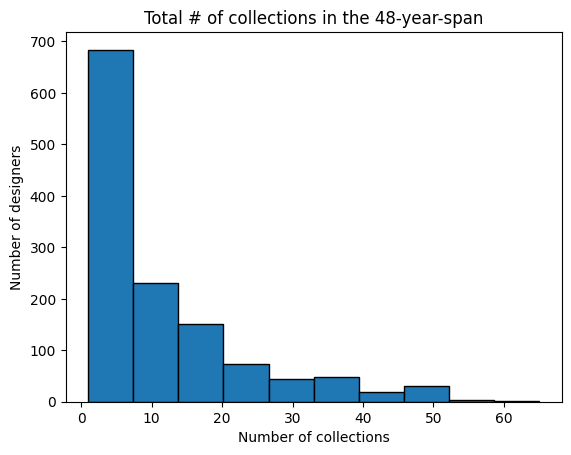

In [240]:
# Plot the distribution
plt.hist(designer_freq['collections'], edgecolor='black')
plt.xlabel('Number of collections')
plt.ylabel('Number of designers')
plt.title('Total # of collections in the 48-year-span')
plt.show()

### Creation of calculated metrics
- *consistency*: The total number of collections made by designer/total # of seasons since the designer’s initial season (inclusive of first season)
- *prevalence*: An adapted version of the consistency metric that penalizes designers who have few collections. This was put in place for two reasons - 1) to penalize designers with high consistency values as a result of having only been around for a short period of time (ex: a designer whose first collection was in the most recent season has a consistency value of 1.0) and 2) to further penalize designers who have low consistency and few collections. I created the prevalence formula using a **penalty term**, $α$.
    - α comes in several forms, listed here in order from least to most severe:
        1. $α = \frac{1}{collections^2}$
        2. $α = \frac{1}{collections}$
        3. $α = \frac{1}{\sqrt{collections}}$
        4. $α = \frac{1}{\sqrt[3]{collections}}$
    - This helps to ensure that designers who have only been in the most recent season (consistency = 1) are not weighted equally with designers who have high consistency values after having been around for many years

In my final analysis, I used the third form of $α$, $α = \frac{1}{\sqrt{collections}}$, as it penalized the brand new designers with high consistency values without limiting high prevalence values to exclusively the oldest, most established designers. 

The metric is then calculated as $prevalence = consistency - \frac{1}{\sqrt{collections}}$.

In [241]:
first_seasons = data.groupby('designer')['seasonyear'].min().to_dict()
designer_freq['first_season'] = designer_freq['designer'].map(first_seasons)
total_seasons = len(data['seasonyear'].unique())
sample = designer_freq.copy()

cons = []

prev_1 = []
prev_2 = []
prev_3 = []
prev_4 = []

for designer in designer_freq['designer']:
    first_season = float(designer_freq[designer_freq['designer']==designer]['first_season'].iloc[0])
    seasons_since = len(data['seasonyear'].unique()[data['seasonyear'].unique() >= first_season])
    collections = float(designer_freq[designer_freq['designer'] == designer]['collections'].iloc[0])
    if first_season == 2023.1:
        seasons_since = 1
    elif first_season == 2023.0:
        seasons_since = 2
    cons.append(collections/seasons_since)
    prev_1.append(collections/seasons_since - (1/collections)**2)
    prev_2.append(collections/seasons_since - 1/collections)
    prev_3.append(collections/seasons_since - 1/np.sqrt(collections))
    prev_4.append(collections/seasons_since - 1/collections**(1/3))
    
    
designer_freq['consistency'] = cons
designer_freq['prev_1'] = prev_1
designer_freq['prev_2'] = prev_2
designer_freq['prev_3'] = prev_3
designer_freq['prev_4'] = prev_4

designer_freq.head()

,designer,collections,first_season,consistency,prev_1,prev_2,prev_3,prev_4
0,comme-des-garcons,65,1991.0,0.984848,0.984612,0.969464,0.860814,0.736137
1,versace,61,1991.0,0.924242,0.923974,0.907849,0.796206,0.670209
2,alexander-mcqueen,57,1995.0,0.982759,0.982451,0.965215,0.850305,0.722917
3,prada,57,1992.0,0.890625,0.890317,0.873081,0.758172,0.630784
4,miu-miu,55,1995.1,0.964912,0.964582,0.946730,0.830072,0.701959


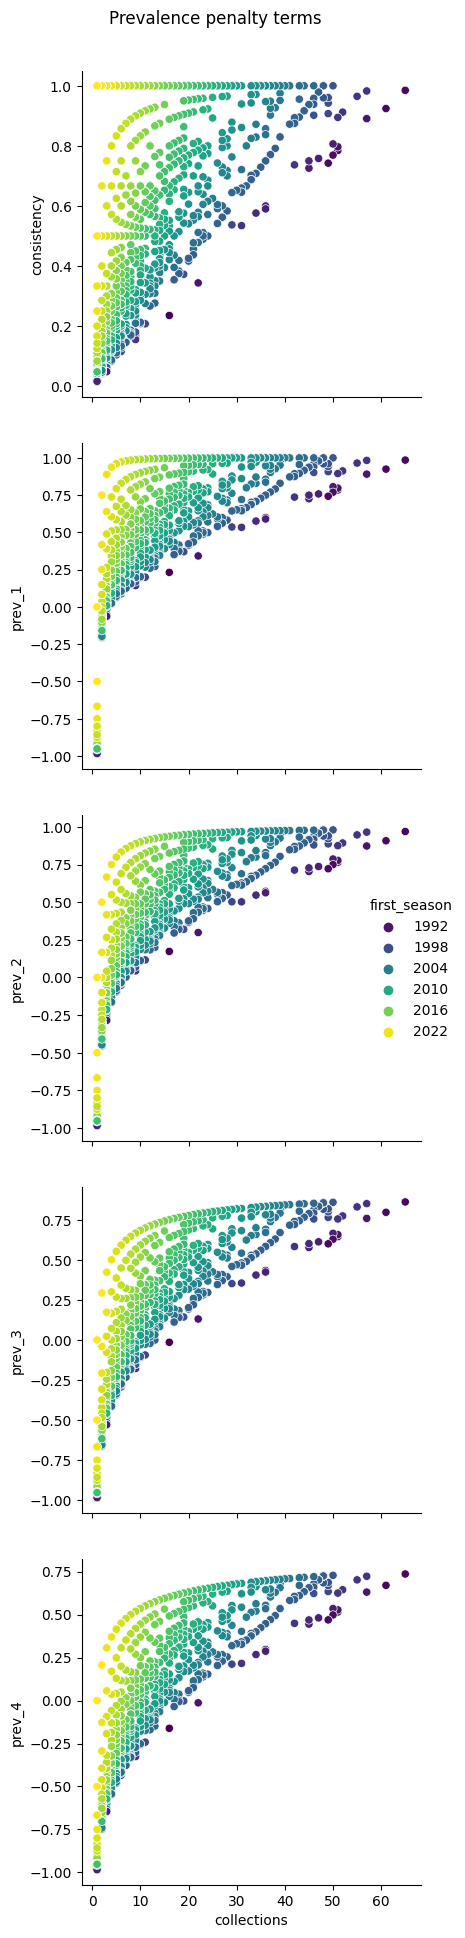

In [242]:
import seaborn as sns
pp = sns.pairplot(data=designer_freq, hue = 'first_season', palette = 'viridis',
                  x_vars=['collections'],
                  y_vars=['consistency','prev_1', 'prev_2', 'prev_3', 'prev_4'], height = 4)
pp.fig.suptitle("Prevalence penalty terms")
plt.tight_layout(pad=3.0)
plt.show()

In [243]:
import numpy as np
designer_freq['prevalence'] = designer_freq['prev_2']
designers = designer_freq[['designer', 'collections', 'first_season', 'consistency', 'prevalence']].copy()

percentile_values = [np.percentile(designer_freq['prevalence'], x) for x in [10, 20, 30, 40, 50, 60, 70, 80, 90, 95]]
class_boundaries = list(percentile_values) + [np.inf]
print(class_boundaries)

def assign_class(value):
    for i, boundary in enumerate(class_boundaries):
        if value <= boundary:
            return i

# Apply assign_class function to calculate class for each designer
designers['class'] = designers['prevalence'].apply(assign_class)


[-0.9523809523809523, -0.3181818181818182, -0.05102564102564103, 0.12611657348499455, 0.3, 0.4681987577639751, 0.6151515151515151, 0.75, 0.9139346884999062, 0.9519047619047617, inf]


In [244]:
designers.groupby('class')[['first_season', 'collections']].describe()

first_season                                                    \
             count         mean       std     min       25%      50%   
class                                                                  
0            143.0  2009.711189  5.125772  1990.0  2006.550  2013.00   
1            123.0  2014.477236  5.841665  2000.0  2012.550  2015.00   
2            120.0  2010.882500  6.968557  1993.0  2006.100  2012.00   
3            128.0  2011.840625  7.750493  1995.0  2006.075  2012.10   
4            132.0  2013.774242  6.288116  1990.0  2010.075  2015.10   
5            125.0  2011.116800  6.145714  1998.1  2007.000  2012.00   
6            130.0  2012.274615  7.411266  1993.1  2008.100  2013.10   
7            128.0  2012.211719  8.442661  1991.0  2006.850  2012.55   
8            127.0  2012.199213  8.346176  1991.0  2006.550  2014.00   
9             64.0  2011.659375  6.488811  1995.1  2007.000  2015.00   
10            65.0  2006.284615  5.390942  1991.0  2000.000  2006.10   

                        collections                                           \
            75%     max       count       mean        std   min    25%   50%   
class                                                                          
0      2013.100  2013.1       143.0   1.000000   0.000000   1.0   1.00   1.0   
1      2018.100  2023.0       123.0   1.642276   0.481291   1.0   1.00   2.0   
2      2017.100  2021.1       120.0   3.225000   0.844781   2.0   3.00   3.0   
3      2018.100  2023.1       128.0   5.054688   2.463301   1.0   4.00   5.0   
4      2018.325  2022.1       132.0   6.977273   3.454096   2.0   5.00   6.0   
5      2016.000  2022.0       125.0  11.952000   5.062283   3.0   8.00  11.0   
6      2016.775  2023.0       130.0  14.046154   8.340488   2.0   9.00  13.0   
7      2020.325  2022.1       128.0  17.328125  11.933615   3.0   5.75  17.0   
8      2019.000  2021.1       127.0  20.661417  14.208884   5.0  10.00  17.0   
9      2016.000  2018.0        64.0  23.812500  12.061845  12.0  16.00  18.0   
10     2011.100  2013.1        65.0  35.000000  10.767428  21.0  25.00  35.0   

                   
        75%   max  
class              
0       1.0   1.0  
1       2.0   2.0  
2       4.0   6.0  
3       6.0  11.0  
4       9.0  22.0  
5      14.0  24.0  
6      19.0  36.0  
7      24.0  50.0  
8      31.0  61.0  
9      33.0  55.0  
10     47.0  65.0

In [245]:
designers.sort_values('consistency', ascending = False)

,designer,collections,first_season,consistency,prevalence,class
1284,tove,1,2023.1,1.000000,0.000000,3
434,rejina-pyo,12,2018.0,1.000000,0.916667,9
492,plan-c,10,2019.0,1.000000,0.900000,8
487,ottolinger,10,2019.0,1.000000,0.900000,8
136,no-21,27,2010.1,1.000000,0.962963,10
...,...,...,...,...,...,...
1184,susan-lazar,1,2000.0,0.020833,-0.979167,0
1265,ghost,1,1999.1,0.020408,-0.979592,0
1270,philip-treacy,1,1997.1,0.018868,-0.981132,0
1278,christian-francis-roth,1,1993.0,0.016129,-0.983871,0


In [246]:
designers.sort_values('prevalence', ascending = False)[120:140]

,designer,collections,first_season,consistency,prevalence,class
73,lela-rose,36,2005.0,0.947368,0.919591,9
33,givenchy,46,1999.1,0.938776,0.917036,9
425,marine-serre,12,2018.0,1.000000,0.916667,9
434,rejina-pyo,12,2018.0,1.000000,0.916667,9
438,calvin-luo,12,2018.0,1.000000,0.916667,9
437,sandy-liang,12,2018.0,1.000000,0.916667,9
37,junya-watanabe,45,2000.0,0.937500,0.915278,9
36,oscar-de-la-renta,45,2000.0,0.937500,0.915278,9
176,mm6-maison-martin-margiela,23,2012.0,0.958333,0.914855,9
100,adam-lippes,33,2006.1,0.942857,0.912554,8


In [247]:
consistency_dict = dict(zip(designers['designer'],designers['consistency']))
prev_dict = dict(zip(designers['designer'],designers['prevalence']))
class_dict = dict(zip(designers['designer'],designers['class']))
data['consistency'] = data['designer'].map(consistency_dict)
data['prevalence'] = data['designer'].map(prev_dict)
data['class'] = data['designer'].map(class_dict)


In [248]:
designers['class'].value_counts()

class
0     143
4     132
6     130
7     128
3     128
8     127
5     125
1     123
2     120
10     65
9      64
Name: count, dtype: int64

In [249]:
designers.to_csv('designers.csv')
data.to_csv('collections.csv')

In [208]:
# Separate features and target
X = data['preprocessed_sentences']
y = data['class']
X

0        enfilad stretchi knit jewel tone effect showma...
1        romeo gigli moment design signatur cocoon shap...
2        alaia work pinstrip power materi season time s...
3        bella hadid remind follow timeless appeal azze...
4        comm garcon rei kawakubo told vogu gift onesel...
                               ...                        
14546    zimmermann australian make instantli recogniz ...
14547    season zuhair murad head circu liter beirut ba...
14548    like self respect italian marco capaldo begin ...
14549    phillip lim kept low profil new york fashion w...
14550    kind time inspir trip sicili sai design stella...
Name: preprocessed_sentences, Length: 14261, dtype: object

In [109]:
names = []
for i in [i.replace('-', ' ') for i in list(designers['designer'])]:
    i = i.split(' ')
    for x in range(len(i)):
        names.append(i[x])
names

['comme',
 'des',
 'garcons',
 'versace',
 'prada',
 'alexander',
 'mcqueen',
 'miu',
 'miu',
 'yohji',
 'yamamoto',
 'michael',
 'kors',
 'collection',
 'dolce',
 'gabbana',
 'gucci',
 'chanel',
 'anna',
 'sui',
 'fendi',
 'balenciaga',
 'louis',
 'vuitton',
 'ann',
 'demeulemeester',
 'moschino',
 'emporio',
 'armani',
 'alberta',
 'ferretti',
 'giorgio',
 'armani',
 'marni',
 'chloe',
 'missoni',
 'carolina',
 'herrera',
 'saint',
 'laurent',
 'valentino',
 'christian',
 'dior',
 'dries',
 'van',
 'noten',
 'jil',
 'sander',
 'burberry',
 'prorsum',
 'maison',
 'martin',
 'margiela',
 'marc',
 'jacobs',
 'ralph',
 'lauren',
 'lanvin',
 'givenchy',
 'emilio',
 'pucci',
 'hermes',
 'oscar',
 'de',
 'la',
 'renta',
 'calvin',
 'klein',
 'collection',
 'john',
 'galliano',
 'junya',
 'watanabe',
 'badgley',
 'mischka',
 'stella',
 'mccartney',
 'vera',
 'wang',
 'max',
 'mara',
 'roberto',
 'cavalli',
 'celine',
 'rick',
 'owens',
 'narciso',
 'rodriguez',
 'bottega',
 'veneta',
 'diane

In [113]:
from sklearn.model_selection import train_test_split
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify = y)

X_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify = y_test, random_state=42)

print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

Training samples: 10185
Validation samples: 2910


In [114]:
X_train[:5]
import random

# sample a random sentence from the training set
random_idx = random.randint(0, len(X_train))
print(f'Random sentence: {X_train.iloc[random_idx]}')
print(f'Author: {y_train.iloc[random_idx]}')

Random sentence: mulberri johnni coca set scene english countri garden parti present pari todai cucumb sandwich pile strawberri tea brew fine china pot lobbi guest arriv britannia theme continu upstair video instal director sharna osborn inspir royal ascot ladi dai think model leap slow motion surrealist confectionari like hat perch head ruffl ruch dress linen suit dot room sens leviti them—both liter figuratively—that lack past nice wai set mood particularli combin cheeri citru palett includ lime color pop season long coca abandon experiment volumin proport altogeth evolv colleg stripe cover overs fall look draw idea deck chair instead incorpor billowi ruffl blous midi skirt spaghetti strap sundress silhouett print blue red wedgwood style pattern ey catch us porcelain china motif resin heel mulberri midi pump look like upsid teacup fair accessori took center stage showroom todai endless iter charm novelti shoe trim mink embellish crystal bag option mix includ soft tradit ladi bag gath

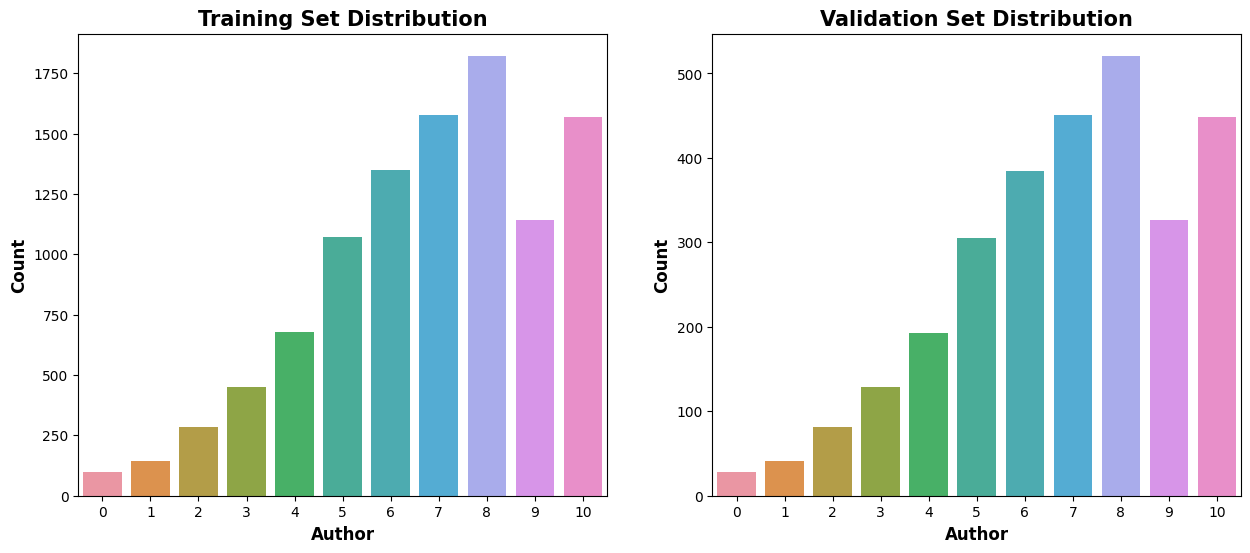

In [115]:
# plot the distribution of the target classes in the training and validation set on a countplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# first plot is the training set
sns.countplot(data = y_train.to_frame(name = 'Class').sort_values('Class'), x = 'Class',ax=ax[0])
ax[0].set_title('Training Set Distribution', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0].set_xlabel('Author', fontsize = 12, fontweight='bold') 
ax[0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# second plot is the validation set

sns.countplot(data = y_val.to_frame(name = 'Author').sort_values('Author'), x = 'Author', ax=ax[1])
ax[1].set_title('Validation Set Distribution', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1].set_xlabel('Author', fontsize = 12, fontweight='bold') 
ax[1].set_ylabel('Count', fontsize = 12, fontweight='bold') 
plt.show()

In [116]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_ohe = ohe.fit_transform(np.array(y_val).reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (10185, 11)
One hot encoded validation labels shape: (2910, 11)


In [117]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.fit_transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (10185,)
Label encoded validation labels shape: (2910,)


In [118]:
for i in range(5):
    print(f'Original label: {y_train.iloc[i]} - Label encoded: {y_train_le[i]}')

Original label: 8 - Label encoded: 8
Original label: 7 - Label encoded: 7
Original label: 7 - Label encoded: 7
Original label: 8 - Label encoded: 8
Original label: 7 - Label encoded: 7


In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [120]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', SVC(kernel='rbf', C = 1.51, random_state=42))
])
# fit the model
text_clf.fit(X_train, y_train_le)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', SVC(C=1.51, random_state=42))])

In [121]:
text_clf.score(X_val, y_val_le)

0.7353951890034365

In [122]:
y_pred = text_clf.predict(X_val)

In [125]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val_le, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.43      0.59        28
           1       0.42      0.12      0.19        41
           2       0.00      0.00      0.00        81
           3       0.67      0.05      0.09       129
           4       1.00      0.13      0.23       193
           5       0.92      0.61      0.74       305
           6       0.82      0.77      0.80       385
           7       0.73      0.88      0.80       451
           8       0.55      0.96      0.70       521
           9       0.94      0.87      0.90       327
          10       0.80      0.95      0.86       449

    accuracy                           0.74      2910
   macro avg       0.71      0.52      0.54      2910
weighted avg       0.76      0.74      0.69      2910



## Recurrent Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = clf.predict(X_test_tfidf)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Assume df is your DataFrame containing text descriptions and designer names

# Preprocess text and compute TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['preprocessed_sentences'])

# Compute pairwise cosine similarity between designers
similarity_matrix = cosine_similarity(tfidf_matrix)

# Thresholding
threshold = 0.2  # Adjust threshold as needed
similarity_matrix[similarity_matrix < threshold] = 0

# Create designer similarity network
G = nx.Graph()
designers = data['designer'].unique()
G.add_nodes_from(designers)

# Add edges based on similarity scores
for i, designer1 in enumerate(designers):
    for j, designer2 in enumerate(designers):
        if i != j and similarity_matrix[i, j] > 0:
            G.add_edge(designer1, designer2, weight=similarity_matrix[i, j])

# Visualize the network
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos = pos, with_labels=True)
plt.show()

# Analyze the network
# Example: Compute degree centrality
degree_centrality = nx.degree_centrality(G)
print(degree_centrality)


In [75]:
degrees_dict = dict(G.degree())
dirs = sorted(degrees_dict, key=degrees_dict.get, reverse=True)[:10]

for dir in dirs:
  print('Director:',dir+ ',  degree:',degrees_dict[dir])

Director: rr331,  degree: 24
Director: thakoon,  degree: 22
Director: moschino-cheap-chic,  degree: 22
Director: ariunaa-suri,  degree: 22
Director: wendelborn,  degree: 22
Director: celine,  degree: 21
Director: trussardi,  degree: 21
Director: michael-angel,  degree: 21
Director: barbara-casasola,  degree: 21
Director: facetasm,  degree: 21


/Users/bellagracefinck/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


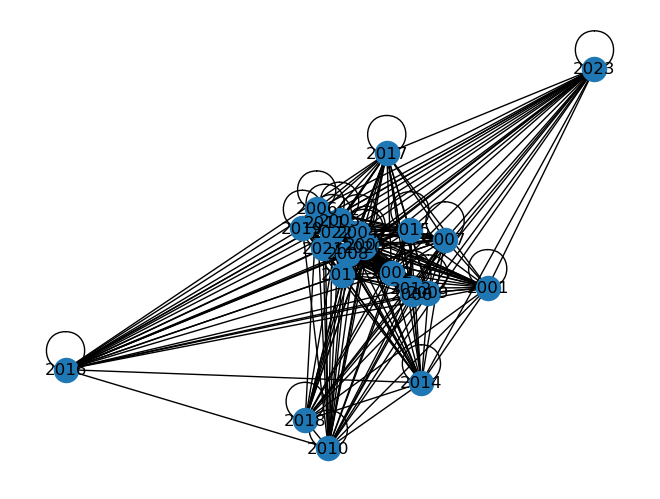

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import networkx as nx
import itertools


# Feature Engineering
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=1000))  # Adjust max_features as needed
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder()) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'text'),
        ('cat', categorical_transformer, ['season', 'year'])
])

# Combine features
X = preprocessor.fit_transform(data[['text', 'season', 'year']])

# Clustering
kmeans = KMeans(n_clusters=5)  # Adjust number of clusters as needed
clusters = kmeans.fit_predict(X)

data['cluster'] = clusters

# Network Construction
G = nx.Graph()
for cluster_id in data['cluster'].unique():
    designers_in_cluster = data[data['cluster'] == cluster_id]['year'].tolist()
    #print(designers_in_cluster)
    for pair in itertools.combinations(designers_in_cluster, 2):
        if G.has_edge(*pair):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)

# Example: Visualize the network
nx.draw(G, with_labels=True)
plt.show()

In [179]:
# create vectorizer 
vectorizer = TfidfVectorizer(stop_words='english') 
  
# vectorizer the text documents 
vectorized_documents = vectorizer.fit_transform(X) 
  
# reduce the dimensionality of the data using PCA 
pca = PCA(n_components=2) 
reduced_data = pca.fit_transform(vectorized_documents.toarray()) 
  
# cluster the documents using k-means 
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, n_init=5, max_iter=500, random_state=42) 
kmeans.fit(vectorized_documents) 
  
# create a dataframe to store the results 
results = pd.DataFrame() 
results['document'] = sentence 
results['cluster'] = kmeans.labels_ 
  
# print the results 
print(results.sample(5)) 
  
# plot the results 
colors = ['red', 'green'] 
cluster = ['Not Sarcastic','Sarcastic'] 
for i in range(num_clusters): 
    plt.scatter(reduced_data[kmeans.labels_ == i, 0], 
                reduced_data[kmeans.labels_ == i, 1],  
                s=10, color=colors[i],  
                label=f' {cluster[i]}') 
plt.legend() 
plt.show()

AttributeError: 'csr_matrix' object has no attribute 'lower'